In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Part 1 - Data Loading, Cleaning, and Feature Engineering

First is to load `listings_sample.csv` dataset into a pandas DataFrame. 

Then conduct initial data quality checks. 

- By examining the first few rows, I can check for any missing values and review the default data types of each column.
- I converted `list_date` column into `datetime` format to enable further analysis.
- Then create a new column `price_per_sqft`, by dividing the price by the sqft. This metric is essential for comparing property values on a like-for-like basis.

In [15]:
df = pd.read_csv('../data/listings_sample.csv')

print(df.head())
print(df.isnull().sum())
df.info()

df['list_date'] = pd.to_datetime(df['list_date'])
print(f"The listings range from {df['list_date'].min().date()} to {df['list_date'].max().date()}.")

df['price_per_sqft'] = df['price'] / df['sqft']
print(df[['price', 'sqft', 'price_per_sqft']].head())


            id                            address           city state  \
0  MLS-TX-1000           960 Cedar Ct, Frisco, TX         Frisco    TX   
1  MLS-CA-1001       2658 Elm Dr, Santa Clara, CA    Santa Clara    CA   
2  MLS-CA-1002  7199 Birch Way, Mountain View, CA  Mountain View    CA   
3  MLS-TX-1003       7729 Walnut Blvd, Frisco, TX         Frisco    TX   
4  MLS-TX-1004           6284 Oak Ave, Frisco, TX         Frisco    TX   

     price  beds  baths  sqft  \
0   803788     3      3  3892   
1  1908765     3      2  3547   
2   507705     4      3  1575   
3  1016982     4      1  3143   
4   682810     4      1  2663   

                                             remarks agent_id  list_date  \
0  quiet cul-de-sac, two-car garage, near good sc...   AG7396  7/14/2025   
1  fresh paint, new roof 2022, large backyard, HO...   AG3612  12/5/2024   
2  updated kitchen, stainless appliances, fresh p...   AG1995  9/26/2024   
3  granite counters, new roof 2022, tile flooring...

In [16]:
print(df[['price', 'sqft', 'beds', 'baths', 'price_per_sqft']].describe())

              price         sqft        beds       baths  price_per_sqft
count  1.600000e+02   160.000000  160.000000  160.000000      160.000000
mean   1.101729e+06  2380.987500    3.456250    2.156250      452.119885
std    7.879282e+05   985.057563    0.983172    0.687232      230.519406
min    1.751420e+05   809.000000    2.000000    1.000000      183.036332
25%    5.085175e+05  1479.750000    3.000000    2.000000      265.616797
50%    8.630205e+05  2399.000000    3.000000    2.000000      340.672676
75%    1.454584e+06  3158.250000    4.000000    3.000000      608.196822
max    3.528809e+06  4187.000000    5.000000    3.000000      945.615679


# Part 2 - Exploratory Data Analysis (EDA)

After cleaning the data, I need to perform *Exploratory Data Analysis (EDA)* to uncover patterns, relationships, and key insights. The goal is to visually and statistically understand the main characteristics of the dataset.

1. **Bar Chart** (State vs. Price/SqFt): Compare the average `price_per_sqft` between California and Texas, giving a clear, high-level view of the significant market differences.
2. **Histogram** (Price Distribution by State): Visualize the distribution of overall listing prices for both states. Through this, I can have a deep understanding of the common price ranges and the volume of listings at different price points.
3. **Box Plot** (Bedrooms vs. Price/SqFt): Investigate how the number of bedrooms affects the `price_per_sqft`. This can reveal trends in property valuation based on size and layout.
4. **Scatter Plot** (Price vs. SqFt): Examine the fundamental relationship between a property's size (sqft) and its total price.
5. **Summary Table** (By City): Compute key statistics (count, median price, etc.) for each city to provide a more granular view of the different local markets.

/var/folders/tg/wjnx168x1mb2nptzryd4d6v00000gn/T/ipykernel_86188/133401780.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_state.index, y=avg_price_state.values, palette='viridis')
/var/folders/tg/wjnx168x1mb2nptzryd4d6v00000gn/T/ipykernel_86188/133401780.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='beds', y='price_per_sqft', palette='coolwarm')



--- Summary Statistics Table by City ---
               listing_count  median_price  median_sqft  median_price_per_sqft
city                                                                          
Sunnyvale                 17     1680137.0       2851.0             505.157718
Santa Clara               18     1661489.0       2966.5             619.599589
San Jose                  21     1338572.0       2628.0             730.977169
Mountain View             17      963112.0       1820.0             558.436014
Palo Alto                 18      945974.0       2004.0             493.008164
Plano                     21      683476.0       2424.0             261.607168
Frisco                    26      583510.0       2320.0             254.701998
Dallas                    22      528357.0       2307.5             259.729000


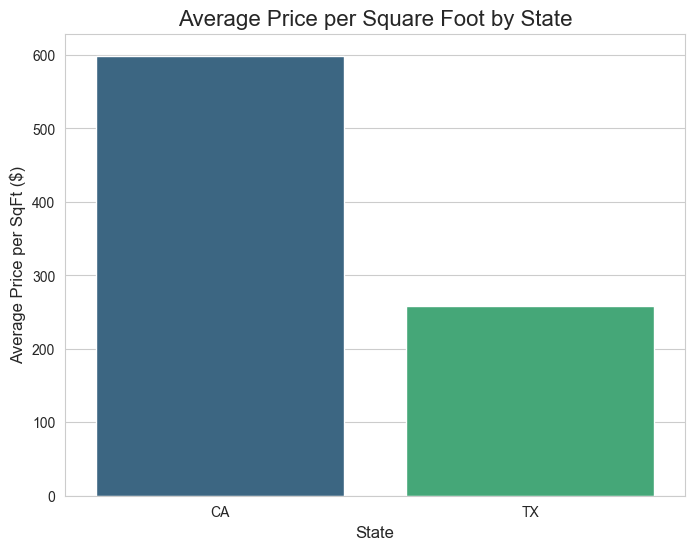

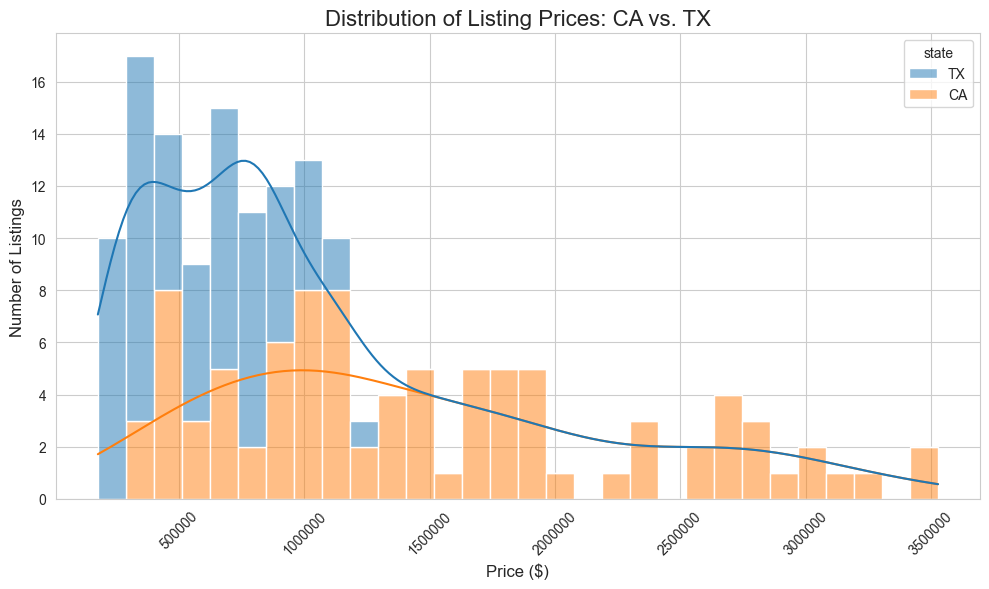

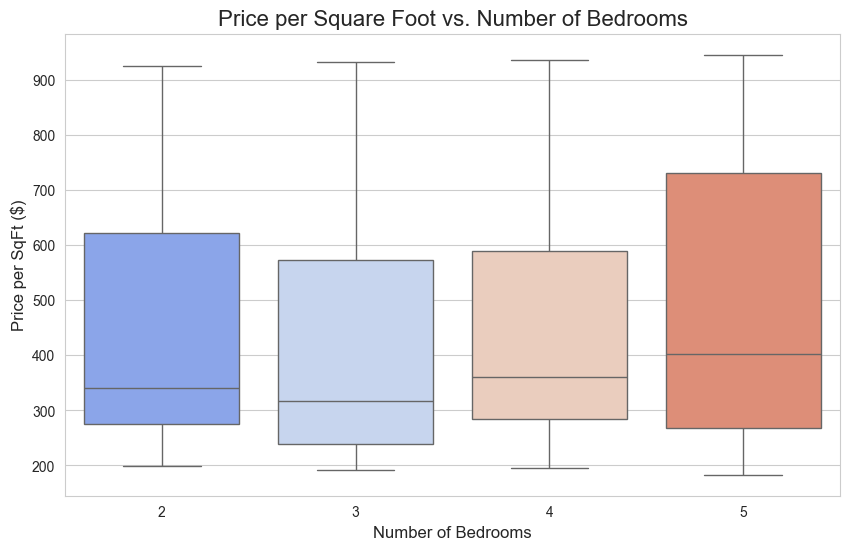

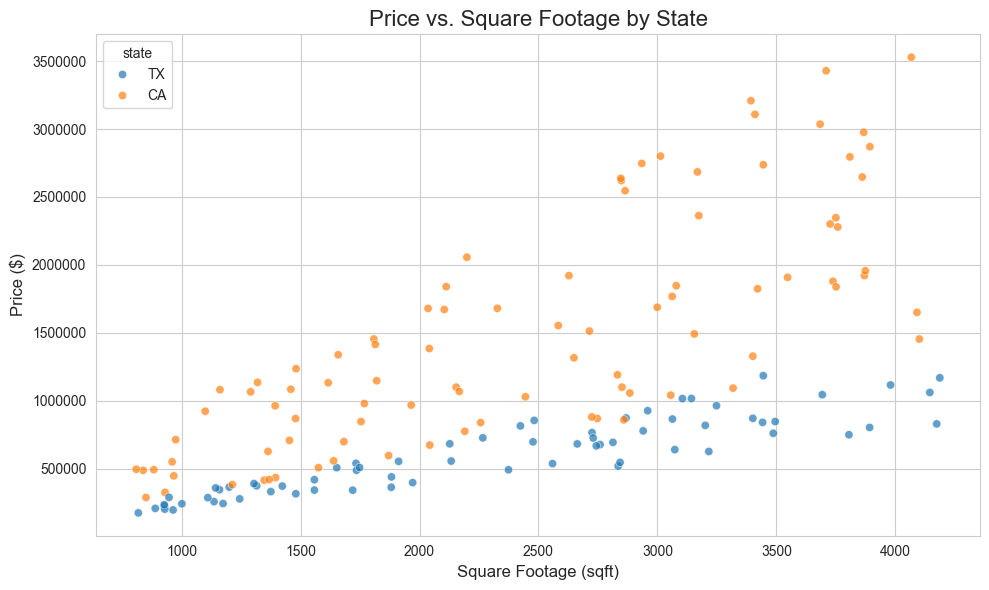

In [17]:
avg_price_state = df.groupby('state')['price_per_sqft'].mean().sort_values(ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(x=avg_price_state.index, y=avg_price_state.values, palette='viridis')
plt.title('Average Price per Square Foot by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Price per SqFt ($)', fontsize=12)
plt.savefig('../results/avg_price_per_sqft_by_state.png')


plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', hue='state', multiple='stack', bins=30, kde=True)
plt.title('Distribution of Listing Prices: CA vs. TX', fontsize=16)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/price_distribution_ca_tx.png')


plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='beds', y='price_per_sqft', palette='coolwarm')
plt.title('Price per Square Foot vs. Number of Bedrooms', fontsize=16)
plt.xlabel('Number of Bedrooms', fontsize=12)
plt.ylabel('Price per SqFt ($)', fontsize=12)
plt.savefig('../results/price_per_sqft_vs_beds.png')


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='sqft', y='price', hue='state', alpha=0.7)
plt.title('Price vs. Square Footage by State', fontsize=16)
plt.xlabel('Square Footage (sqft)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig('../results/price_vs_sqft_by_state.png')


print("\n--- Summary Statistics Table by City ---")
city_summary = df.groupby('city').agg(
    listing_count=('id', 'count'),
    median_price=('price', 'median'),
    median_sqft=('sqft', 'median'),
    median_price_per_sqft=('price_per_sqft', 'median')
).sort_values(by='median_price', ascending=False)
print(city_summary)


# Part 3 - Baseline Predictive Model

This section details the process of building and evaluating a baseline predictive model. The objective of the model is to predict `price_per_sqft` based on a set of property features.

To make the process simpler, this section applies the *Linear Regression* model as the baseline.

1. **Feature Selection & Preparation**: The model utilizes *beds, baths, sqft, and state* as its features. The categorical state feature is converted into a numerical format through one-hot encoding. The `drop_first=True` parameter is set to prevent multicollinearity in the model.
2. **Data Splitting**: The dataset is partitioned into a training set (80% of the data) and a testing set (20%). This separation is prepeared for training the model and subsequently evaluating its performance on data.
3. **Model Training**: The model is trained on the training dataset to learn the relationship between the features and the target variable.
4. **Evaluation**: The model's predictive performance is assessed on the test set. 

The baseline linear regression model explains approximately `53.9%` of the variance in price per square foot using beds, baths, sqft, and state. On average, the model's prediction for price per square foot is off by about `$114.42`.

This indicates that while these basic features have some predictive power, a more complex model or additional features would be needed for higher accuracy.

In [18]:
features = ['beds', 'baths', 'sqft', 'state']
target = 'price_per_sqft'

X = df[features]
y = df[target]
X = pd.get_dummies(X, columns=['state'], drop_first=True)
print(X.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


model = LinearRegression()
model.fit(X_train, y_train)
print("\nLinear Regression model trained successfully.")

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation Results ---")
print(f"Mean Absolute Error (MAE): ${mae:,.2f} per sqft")
print(f"R-squared (R²): {r2:.4f}")


   beds  baths  sqft  state_TX
0     3      3  3892      True
1     3      2  3547     False
2     4      3  1575     False
3     4      1  3143      True
4     4      1  2663      True
Training set size: 128 samples
Testing set size: 32 samples

Linear Regression model trained successfully.

--- Model Evaluation Results ---
Mean Absolute Error (MAE): $114.42 per sqft
R-squared (R²): 0.5386


# Part 4 - RAG System

A pre-trained model (`all-MiniLM-L6-v2`) is loaded from the `SentenceTransformer` library. This model is specifically designed to create meaningful numerical representations (vectors) from text sentences.

In [19]:
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model initialized.")

Model initialized.


In [20]:
corpus = df['remarks'].tolist()
corpus_embeddings = model.encode(corpus, show_progress_bar=True)
print("Embeddings created successfully.")

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Embeddings created successfully.


The following codes defines the `find_relevant_listing` function, which is the core component for executing the retrieval step in the RAG system. The function is designed to accept a text query and return the most relevant documents from the corpus.

In [21]:
def find_relevant_listing(query, top_k=1):
    """
    Finds the most relevant listing remarks for a given query using semantic search.
    """
    query_embedding = model.encode(query)
    
    cos_scores = cosine_similarity([query_embedding], corpus_embeddings)[0]
    
    top_results_indices = np.argsort(cos_scores)[-top_k:]
    
    results = []
    for idx in reversed(top_results_indices):
        results.append({
            "address": df.iloc[idx]['address'],
            "remarks": df.iloc[idx]['remarks'],
            "similarity_score": cos_scores[idx]
        })
    return results


# Part 5 - RAG Q&A Demonstration

In [22]:
print("\n--- RAG Q&A Demonstration ---")

# Example Query 1:
query1 = "Which house has hardwood floors and a two-car garage?"
results1 = find_relevant_listing(query1)

print(f"\n[Query]: {query1}")
if results1:
    print(f"✅ [Best Match Found]: {results1[0]['address']}")
    print(f"💬 [Supporting Text]: '{results1[0]['remarks']}'")
    print(f"(Similarity Score: {results1[0]['similarity_score']:.4f})")
else:
    print("No relevant listing found.")

# Example Query 2:
query2 = "Are there any properties with solar panels near a park?"
results2 = find_relevant_listing(query2)

print(f"\n[Query]: {query2}")
if results2:
    print(f"✅ [Best Match Found]: {results2[0]['address']}")
    print(f"💬 [Supporting Text]: '{results2[0]['remarks']}'")
    print(f"(Similarity Score: {results2[0]['similarity_score']:.4f})")
else:
    print("No relevant listing found.")


--- RAG Q&A Demonstration ---

[Query]: Which house has hardwood floors and a two-car garage?
✅ [Best Match Found]: 6284 Oak Ave, Frisco, TX
💬 [Supporting Text]: 'two-car garage, hardwood floors, vaulted ceilings, fresh paint'
(Similarity Score: 0.6783)

[Query]: Are there any properties with solar panels near a park?
✅ [Best Match Found]: 1241 Elm Dr, Dallas, TX
💬 [Supporting Text]: 'solar panels, large backyard, fresh paint, walk to park'
(Similarity Score: 0.7099)
